# Assignment 1


## Olympics

---

## Business Understanding

---

Todo

## Data Meaning Type

---

Todo

## Data Quality

---

Todo

## Simple Statistics

---

Todo

## Visualize Attributes

---

**Points of interest**

Our olympic data covers information that spans the years 1896 all the way to 2016. This offers us a wealth of information in regards to how well athletes did during this time. There are several interesting questions we chose to answer in order to help us understand this dataset more. The questions are 

- What event awarded the most gold medals in the historical olympic data?
- What does the olympic participation by age group look like?
- Is there a positive Linear Relationship between Gold Medals and weight?
- Is there a positive Linear Relationship between Gold Medals and height?
- Has the amount of summer olympic gold medals acheived by athletes increased over the years?

We begin to visualize and answer these questions next.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [18]:
df = pd.read_csv('data/athletes_cleaned_merged.csv')

#### What event awarded the most gold medals in the historical olympic data?


In [3]:

medal_count_by_event = df[df['Medal'] == 'Gold'].groupby(['Event'])['Medal'].count().sort_values(ascending=False)

Text(0.5,1,'Gold Medals awarded by Event From 1896 to 2016')

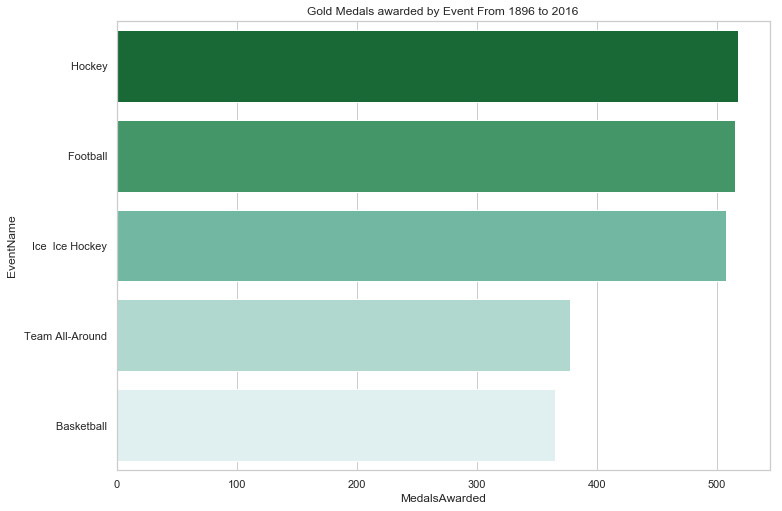

In [27]:
data_of_interest = medal_count_by_event[0:5]
chartdata = pd.DataFrame({'EventName': data_of_interest.index,
                         'MedalsAwarded': data_of_interest.values})

sns.barplot('MedalsAwarded', y='EventName', data=chartdata, 
            palette='BuGn_r', orient="h").set_title("Gold Medals awarded by Event From 1896 to 2016")

We can see from the chart above Hockey has had the most awarded Gold Medals between the years of 1896 to 2016. However, visually there does not appear to be that much of a difference between Ice Hockey and Football. Those two events seem to be separated by only a few medals. If medal prediction is our goal here it is useful to know which event saw the most Gold Medal activity.

#### What does the olympic participation by age group look like?

We know the ages of all the athletes to participate in the olympics. We decided that it would be interesting to know what the participation in the olympics looks like visualized by age group.

In [127]:
count_by_age = df.groupby(['Age', 'Season'])['Age'].count()
age_group_df = df[['Season', 'Age']].groupby(['Season','Age']).count().reset_index()
age_group_df['TimesAgeParticipated'] = count_by_age.values

1

In [121]:
def form_age_group(age):
    if age >= 13 and age <= 24:
        return 'Ages 13 to 24'
    elif age >= 25 and age <= 35:
        return 'Ages 25 to 35'
    elif age >= 36 and age <= 50:
        return 'Ages 36 to 50'
    else:
        return 'Ages 51 and Older'
    
age_group_df['AgeGroup'] = age_group_df['Age'].apply(form_age_group)

Text(0.5,1,'Olympic Participation Numbers By Agegroup From 1896 to 2016')

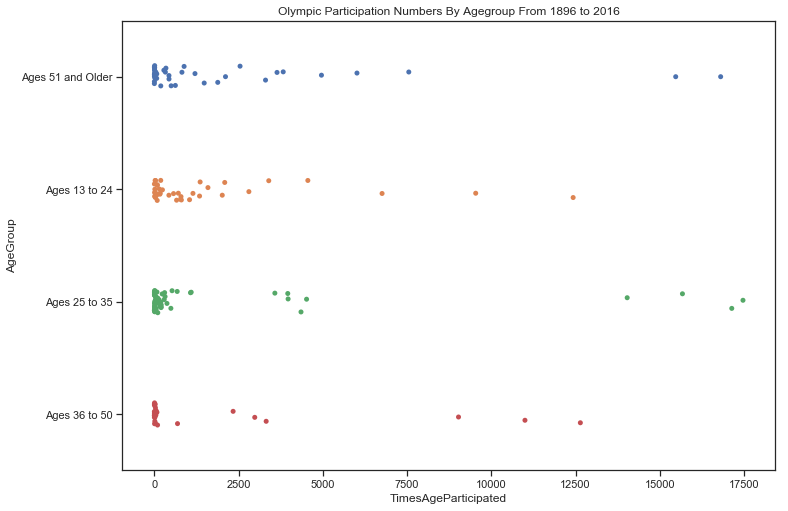

In [124]:
sns.stripplot(x="TimesAgeParticipated", y="AgeGroup", data=age_group_df, orient='h')
plt.title('Olympic Participation Numbers By Agegroup From 1896 to 2016')

The chart above gives us an idea of the different age groups we have participating in our olympic data. We have divided our data into 4 age groups and counted the number of athletes that were at that specific age when they participated in the olympics. These Frequencies are illustrated with the points on the chart to show how common it was to have participants enter the games at their specific ages. On the left side of the chart we expect to see larger clusters for all groups which indicates the most common times these ages groups are seen is somwhere between 1 and 5000 throughout all the olympic historical data. However, whats shocking about this is Age group 50 and Older has some representation on the right side of the chart right along with Age group 25 to 35. This was suprising, as it shows that it is not uncommon to see older athletes in this dataset.

#### Is there a  positive Linear Relationship between Gold Medal Winners and weight?

Text(0.5,1,'Weight vs GoldMedalsWon')

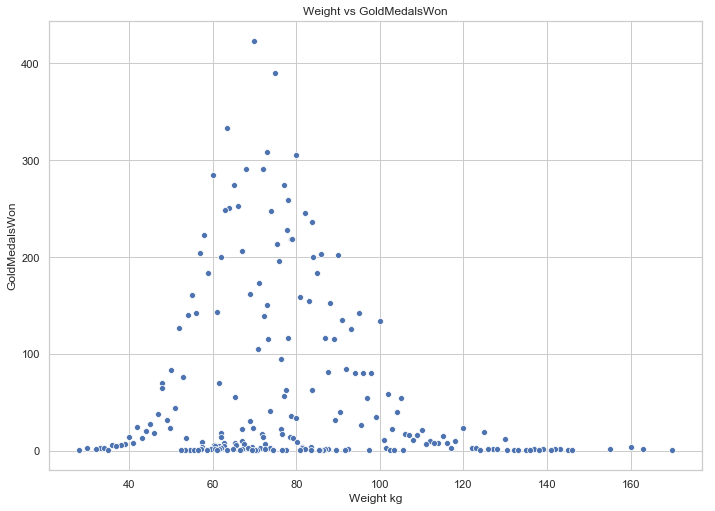

In [24]:
weight_info = df[df['Medal'] == 'Gold'].groupby(['Weight'])['Medal'].count().sort_values(ascending=False)
weight_df = pd.DataFrame({'Weight kg': weight_info.index,
                         'GoldMedalsWon': weight_info.values })

weight_df
sns.scatterplot(x="Weight kg", y="GoldMedalsWon",
                data=weight_df)
plt.title("Weight vs GoldMedalsWon")

Whats interesting about the chart above is we can see that we don't have a linear relationship between `Weight kg` and `GoldMedalsWon`. However, there is a clear normal distribution with a skewed right tale. This might indicate that the majority of the gold medal winners are going to fall in between the range of `40kg` to `100kg` before it becomes less likely that they will win a Gold medal. This could be a small clue for us that something is going on as far as Weight and how it affects Gold Medal totals. 

#### Is there a positive Linear Relationship between Gold Medals and height?


Text(0.5,1,'Height vs GoldMedalsWon')

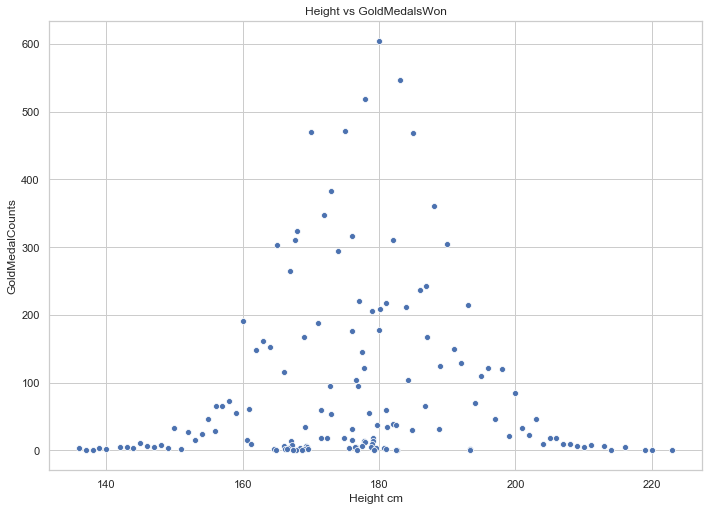

In [23]:
height_info = df[df['Medal'] == 'Gold'].groupby(['Height'])['Medal'].count().sort_values(ascending=False)
height_df = pd.DataFrame({'Height cm': height_info.index,
                         'GoldMedalCounts': height_info.values})
sns.set_style("whitegrid")
sns.scatterplot(x='Height cm', y='GoldMedalCounts', data=height_df)
plt.title("Height vs GoldMedalsWon")

Once again we see  a normal distribution when we compare `GoldMedals` to Height. We can also clearly see we don't have linear relationship, between the two variables so this suggests that linear models are not going to fit this data well. It is important to note that the majority of the datapoints seem to fall between 160 and 200 cm's. This chart visually suggests that the 160 to 200 cm height interval might see a greater number of Gold medals won than those in the Higher or lower ranges.

#### Has the amount of summer olympic gold medals acheived by athletes increased over the years?

Text(0.5,1,'Awarded Summer Olympic Gold Medals overtime')

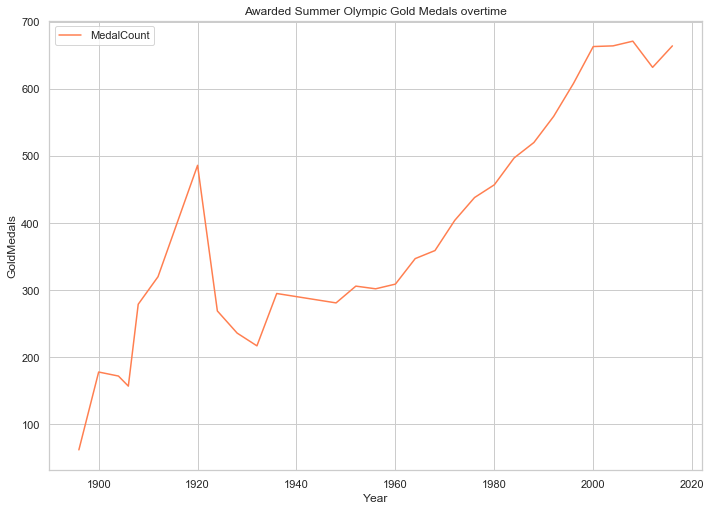

In [25]:
year_info = df[(df['Medal'] == 'Gold') & (df['Season'] == "Summer")].groupby(['Year'])['Medal'].count()
year_df = pd.DataFrame({'Year': year_info.index,
                       'GoldMedals': year_info.values})
sns.lineplot(x=year_df['Year'], y=year_df['GoldMedals'], color="coral", label="MedalCount")
plt.title('Awarded Summer Olympic Gold Medals overtime')

The chart above tracks the way the The awarding of gold medals have been moving over time. Our dataset begins in 1896 and we have entries all the way until 2016. Whats really interesting here is that the pattern starts a smooth upward trajectory right around 1940. Right before the 2000 olympics a plateau starts to develop where you see the winnings peak for gold medals. It will be interesting to see how the coming years change the trajectory of the chart.  We can conclude that based on this chart Gold medals have become extremely difficult to obtain between 2000 and 2016 and might have peaked. Could this be due to more events being added, or increased competition?

## Explore Joint Attributes

---

#### Age, Weight, and Height, and the relationship to Gender

In order to get a good idea of the relationship between variables we examine a scatter plot of our quantitative variables. In our olympic dataset the quantitative variables of interest are of course `Age`, `Weight` and `Height`. We view the relationship of the variables by `Gender`.


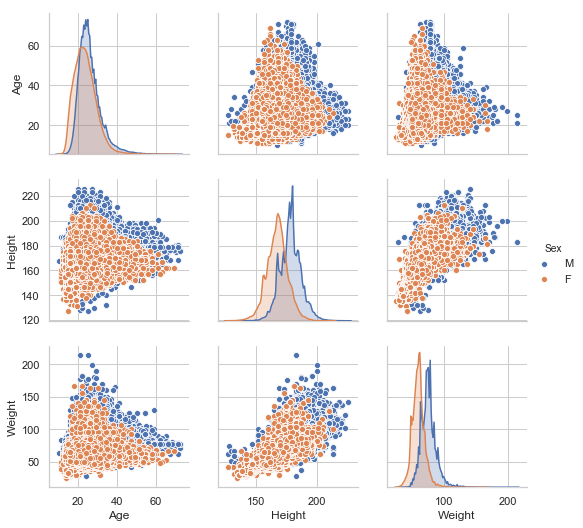

In [28]:
sns.pairplot(df,
             vars=['Age', 'Height', 'Weight'],
             hue='Sex', height=2.5)

We examine a pair scatter plot above to get a good idea of what the `Age`, `Weight`, and `Height` look like for our athletes. Men and women have different builds as well as body types so it was neccessary to separate the two groups by the `Sex` variable. What we found interesting here is  how closely the shape of the data matches regardless of gender.

Take `Age` and its relationship with `Weight` on the bottom left of the chart. If we look at the bulk of the clustering men and women both appear to take the same form. An even better view is the spread of the `Weight` on the far right of the bottom row. There is a slight shift to the right for men while women have a slight shift to the left. This suggest that the difference in `Weight` spread might not be something we can ignore with this variable when we proceed to modeling. 

The Males have higher peaks on their distributions for `Age`, `Weight`, and `Height`. However, the distribution shapes don't appear to diverge much between Genders as a whole. The only notable divergence is perhaps, `Weight` and `Height`, but even thats pretty close.

It is also important to note that Males `Age` Has a higher peak than that of the women. The Top athletic Age for women seems to be around 80 years while the historical data has shown `Men` that were almost 100 years old.

We might need to use a much more specific and identifiable metrics like `BMI` in order to have a good idea of the significant differences between the athletes as it is not easy to tell the difference visually. If we where to remove the Color coding for male and female it would look like all the data is from the same distribution in many of these quantitative catagories.

#### Which Team won the most olympic GOLD medals between from 1896 to 2016?

This dataset covers olympic data all the way back to 1896. It would be interesting to find out how which team won the most gold medals regardless of the type of the olympics whether it be `Summer` or `Winter`. The variables we will need to explore is `Team` and `Medal` counts.

In [12]:
won_gold = df['Medal'] == 'Gold'
gmc = df[won_gold].groupby(['Team'])['Medal'].count().sort_values(ascending=False)


In [13]:
gold_medal_counts = pd.DataFrame({'Team':gmc.index,
                                  'Gold Medals':gmc.values})

gold_medal_counts.head(10)

,Team,Gold Medals
0,United States,2468
1,Soviet Union,1058
2,Germany,668
3,Italy,530
4,Great Britain,499
5,Sweden,449
6,France,445
7,Hungary,431
8,Canada,422
9,East Germany,369


If we look at the Top ten Gold medal winners for the olympics we can see `United States` has historical won the most gold Medals. The `Soviet Union` comes in second while the third is `Germany`. To give a good idea of the counts visually we use the chart below.

Text(0.5,1,'Olympic Gold Medal Totals From 1896 to 2016')

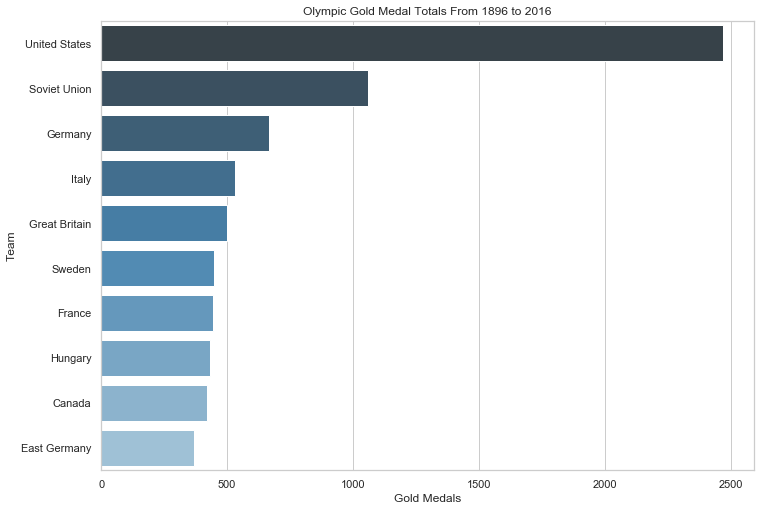

In [29]:
sns.barplot('Gold Medals', y='Team',
            data=gold_medal_counts.head(10), 
            palette='Blues_d', orient="h").set_title("Olympic Gold Medal Totals From 1896 to 2016")

We can see visually the top ten countries in our olympic data by the amount of gold medals won. This is significant as we can use this to understand the proportions of the gold medal winning by country. The model can use this information in order to successfully predict which medal was won based on the team varaible being included in the model.

#### Athletes BMI and its relationship to time

Another Joint releationship we wish to understand is how our athletes `Ages`, `weights` and `Height` are related to our timeline. We saw earlier that there is an interesting pattern with the amount of gold medals awarded throughout all the years the olympic data has been collected. It might also be a good idea for us to take a look at whether or not there is any correlation between time and our physical descripters of the atheletes.

We can't view Age, Weight, and height clustered together for all althletes so we will instead use the `BMI` as our metric. Our `BMI` will be calculated as..

$$
BMI = \left(\frac{\omega}{\eta \times \eta}\right) \times C
$$

where $\omega$ represents our athletes weight in kilograms, and $\eta$ represents our athletes height in centimeters, and $C$ is our constant at `10,000`.

Text(0.5,1,'Olympic Athelete BMI overtime 1896 to 2016')

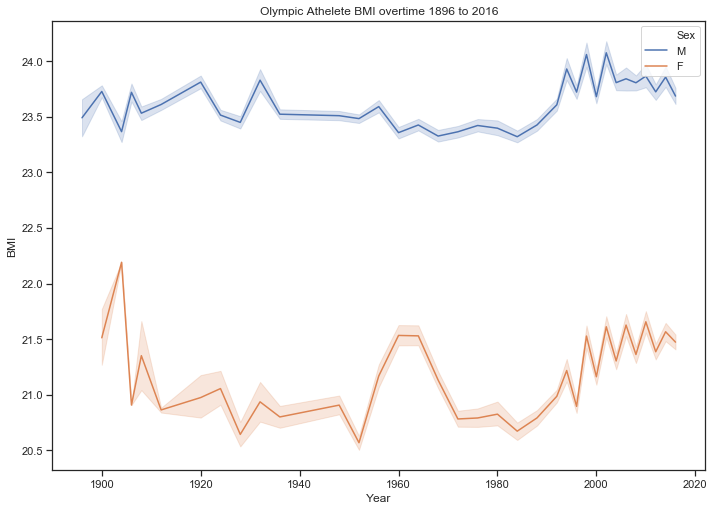

In [30]:
sns.set_style('ticks')

def calculate_bmi(df):
    return (df[1]/(df[0] * df[0])) * 10000

sub_data = df[['Year', 'Height', 'Weight','Age', 'Sex']].sort_values(ascending=True, by='Year')

sub_data['BMI'] = sub_data[['Height', 'Weight']].apply(calculate_bmi, axis=1)

sns.lineplot(x='Year', y='BMI', hue='Sex', data=sub_data)
plt.title('Olympic Athelete BMI overtime 1896 to 2016')

The chart above gives us a good example of how the `BMI` for olympic athletes has fluctuated overtime. What is interesting to note is our range goes from a index of `20.5` and `24.0`. There is a notable difference in the BMI for Males and Females, so we visualize this change over time segmented by the two groups. The Males have been steady as the years passed between the 1900 to 1980, however during the early 2000's we can see a slight uptick in the `BMI` of male athletes. This could indicate that modern athletes are getting a it bigger than they were in the early 1900s. On the female side of the chart we can see the opposite trend. It looks as though the females have started out with a high BMI, but started to move away from the historical peak BMI
in the early 1900's.  It would be interesting to see how the BMI changes over the next 20 years for both sexes in the future.

#### How are medals regardless of Gold, Silver, or bronze spread out through the years.

Earlier we looked at which sport awarded the most gold medals, now we will get an idea how the medals were awarded regardless of the type of medal. This will be interesting to see because it could give us insite as to what sports an athletes have been medaling in.

Text(0.5,1,'Summer Olympic Medal Volume accross all Sports from 1896 to 2016')

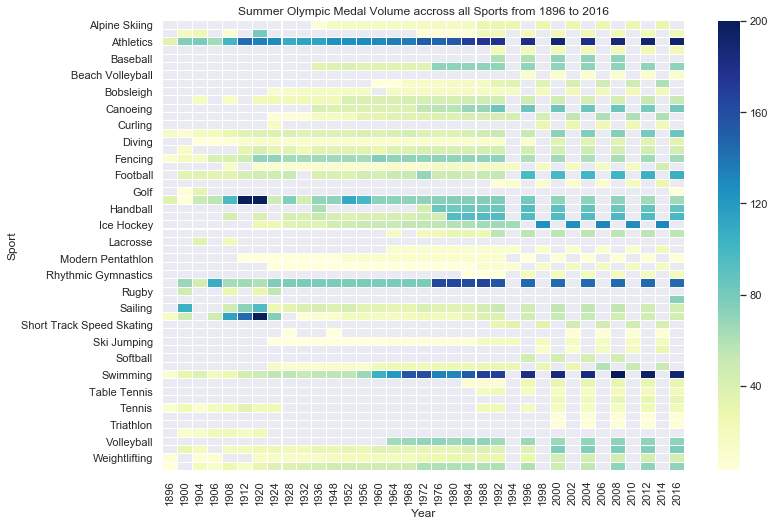

In [22]:
medals_data = df[(df.Medal != 'No Medal') & (df.Season != 'winter')]
all_medals = medals_data.groupby(['Sport', 'Year'])['Medal'].count()


medal_count = all_medals.values
medals_by_sport = medals_data[['Sport', 'Year', 'Medal']].groupby(['Sport', 'Year'])['Medal'].count()
mdf = medals_by_sport.reset_index()

mdf['Year'] = mdf['Year'].astype(int)

sns.heatmap(mdf.pivot("Sport", "Year", "Medal"),linewidths=.02, cmap="YlGnBu")
plt.title("Summer Olympic Medal Volume accross all Sports from 1896 to 2016")

Above we have a heat map of all our olympic sport catagories that take place in the summer games. On the far right of the graph we have the amount of medals regardless of the level of medal. The Darker the color the more medals received. The lighter the color the less medals received. It is also important to understand that the grey areas does not indicate that no medals have been awarded in those sports, it just simply indicates that the volumn of medals that was received was not enough to color the chart. With respect to time we can see that Medals started to become more common for the athletes the closer we get to the 2000's as more sport catagories are represented by all the colors on the heat map.

## Explore Attributes and Classes

---

Todo

## New Features

---

Todo

## Exceptional Work

---

Todo